In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

# display 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning and Preperation 

In [4]:
# this shows that this has ~500,000 rows, 8 columns 

In [5]:
df.shape

(541909, 8)

In [6]:
# InvoiceNo - object - OrderID
# StockCode - object - ProductID
# Description - object - product name 
# Quality - int64 - units purchased 
# InvoiceDate - object - ??? - needs to be converted to time since its an object 
# UnitPrice - float64 - price per unit 
# CustomerID - float64 - Missing values 
# Country - object - Geo

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
# Filtering out UK
df_uk = df[df['Country'] == 'United Kingdom']
df_uk.shape

(495478, 8)

In [9]:
# Cleaning Transactional Noise (This removes Returns and Free/Invalid Items, Prevents negative values)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df_uk.shape

(495478, 8)

In [10]:
# Fixing data types

In [11]:
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

In [12]:
# Rechecking
df_uk.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [13]:
df_uk['TotalSales'] = df_uk['Quantity'] * df_uk['UnitPrice']

In [14]:
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

In [15]:
df_uk['InvoiceDate'].dtype

dtype('<M8[ns]')

In [16]:
# Creating Month and Month Name
df_uk['Month'] = df_uk['InvoiceDate'].dt.month
df_uk['Weekday'] = df_uk['InvoiceDate'].dt.day_name()
df_uk['Hour'] = df_uk['InvoiceDate'].dt.hour

In [17]:
# Computing monthly sales 
monthly_sales = df_uk.groupby('Month')['TotalSales'].sum().sort_index()
monthly_sales

Month
1      434308.300
2      408247.910
3      559707.390
4      442254.041
5      596459.860
6      554478.350
7      565479.841
8      539130.500
9      862018.152
10     877438.190
11    1282805.780
12    1065478.050
Name: TotalSales, dtype: float64

# Exploratory Analysis

## Business Question 1: When do customers buy the most (monthly)? 

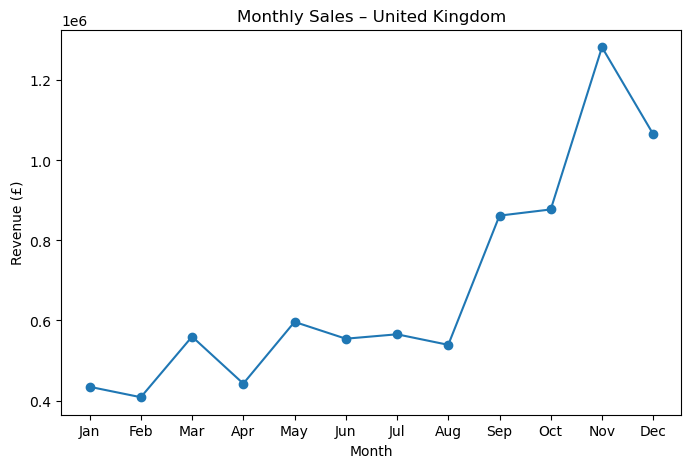

In [20]:
plt.figure(figsize=(8,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Monthly Sales – United Kingdom')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

## Monthly Sales - United Kingdom (Seasonal)
* For this, sales are steady from January - August with roughly £450k–£650k per month 
* People tend to start shopping for the holidays around september and that momentum increases with a massive peak at November & December (£450k–£650k per month). 

### Why this matters: 
* This particular retail business is gift-oriented
* Q4 is around December = holiday season (Christmas, New Years, end-of-year sales)
* Customers wait until the last minute to buy what they need
* Business also buy for the holidays 

### Key Take Away: 
Most of its yearly income arrives in Q4, making operations heavily dependent on that period. Because of this pattern, stock levels need careful adjustment ahead of peak demand. Workforce size may require temporary expansion when activity spikes. Money coming in tends to cluster late, affecting how funds are allocated earlier. Advertising budgets might work better if shifted closer to high-sales months. 

## Business Question 2: When do customers buy the most (Day and Hours)? 

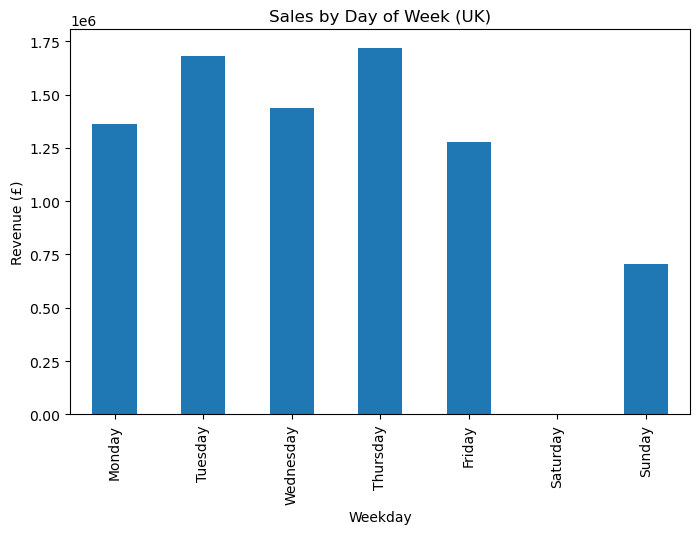

In [25]:
# Sales by Weekday 
weekday_sales = (
    df_uk
    .groupby('Weekday')['TotalSales']
    .sum()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)

weekday_sales.plot(kind='bar', figsize=(8,5), title='Sales by Day of Week (UK)')
plt.ylabel('Revenue (£)')
plt.show()

## Sales by Day of the Week (UK)
*  Tuesday and Thursday are the strongest revenue days for UK shopping markets which Monday and Friday dominate.
*  Saturday doesn't include any data
*  Sunday is much slower than weekdays 

### Why this matters: 
* B2B / Wholesale-Style ordering 
* This shows that orders are places during working hours 
* Saturdays may not have activity due to them likely being closed on that day 

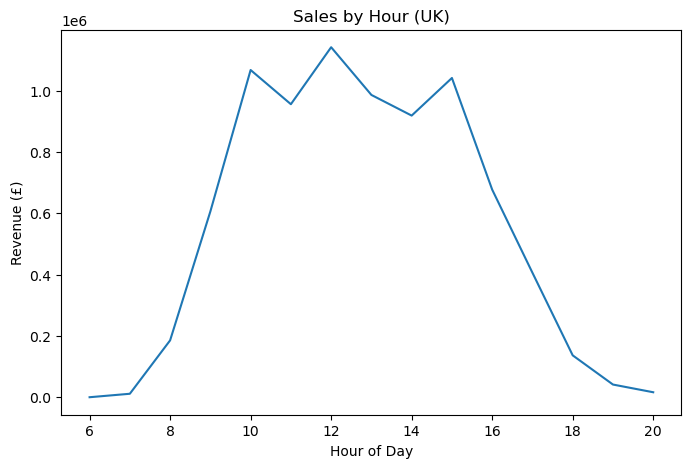

In [28]:
# Sales by Hours 
hourly_sales = df_uk.groupby('Hour')['TotalSales'].sum()

hourly_sales.plot(kind='line', figsize=(8,5), title='Sales by Hour (UK)')
plt.xlabel('Hour of Day')
plt.ylabel('Revenue (£)')
plt.show()

## Sales by Hour (UK)
*  Sales begin to increase around 9AM
*  Peak revenue between 10 AM - 3 PM
*  As the day goes on, a sharp decline after 4-5 PM

### Why this matters: 
The orders are placed during business hours 
<br>
Pattern: 
   - Mornings: orders are placed
   - Midday: highest volume of shoppers
   - Afternoon: fufilment/cutoff

## Business Question 3: Which products are bestsellers (Top 10)? 

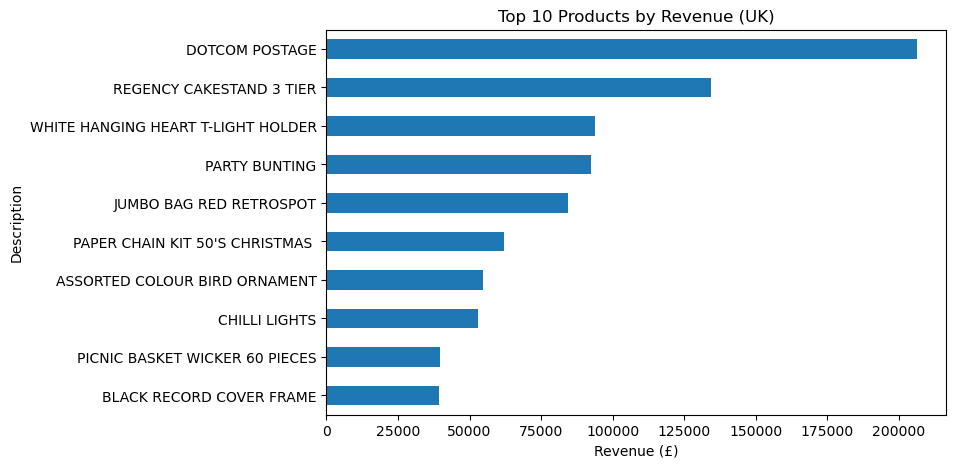

In [32]:
top_products = (
    df_uk
    .dropna(subset=['Description'])
    .groupby('Description')['TotalSales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_products

top_products.sort_values().plot(
    kind='barh',
    figsize=(8,5),
    title='Top 10 Products by Revenue (UK)'
)
plt.xlabel('Revenue (£)')
plt.show()

DOTCOM POSTAGE can be interpreted as shipping costs which represents a significant revenue stream especially for large and frequent orders

# Forecasting Extension: Monthly Sales Forecast (UK)

In [35]:
# Set InvoiceDate as a time index, Resamples by month, sums revenue per month

In [36]:
monthly_ts = (
    df_uk
    .set_index('InvoiceDate')
    .resample('M')['TotalSales']
    .sum()
)

monthly_ts.head()

/var/folders/1v/dly695fn2gx62sj5h608jr980000gn/T/ipykernel_51343/238979420.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['TotalSales']


InvoiceDate
2010-12-31    676742.620
2011-01-31    434308.300
2011-02-28    408247.910
2011-03-31    559707.390
2011-04-30    442254.041
Freq: ME, Name: TotalSales, dtype: float64

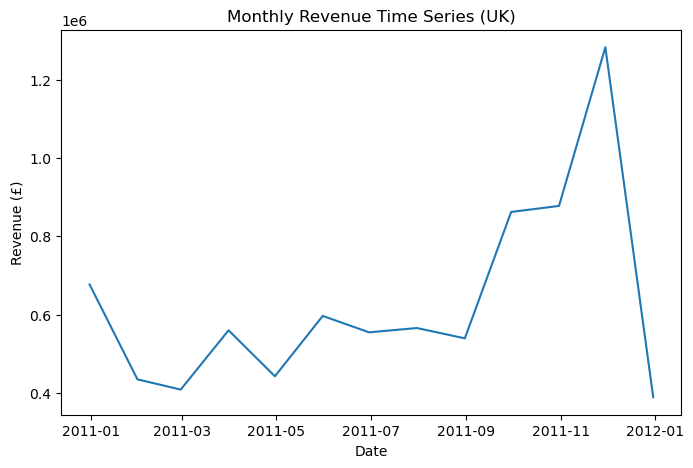

In [37]:
plt.figure(figsize=(8,5)) 
plt.plot(monthly_ts)
plt.title('Monthly Revenue Time Series (UK)')
plt.xlabel('Date')
plt.ylabel('Revenue (£)')
plt.show()

## Fitting Exponential Smoothing Model 
Im going to be using it since it works well with seasonal business data 

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# if monthly_ts is a Series indexed by month end dates
model = ExponentialSmoothing(
    monthly_ts,
    trend='add',
    seasonal=None,
    initialization_method="estimated"
)

hw_fit = model.fit()

forecast = hw_fit.forecast(6)
forecast

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2012-01-31    737515.211298
2012-02-29    757672.492753
2012-03-31    777829.774208
2012-04-30    797987.055663
2012-05-31    818144.337119
2012-06-30    838301.618574
Freq: ME, dtype: float64

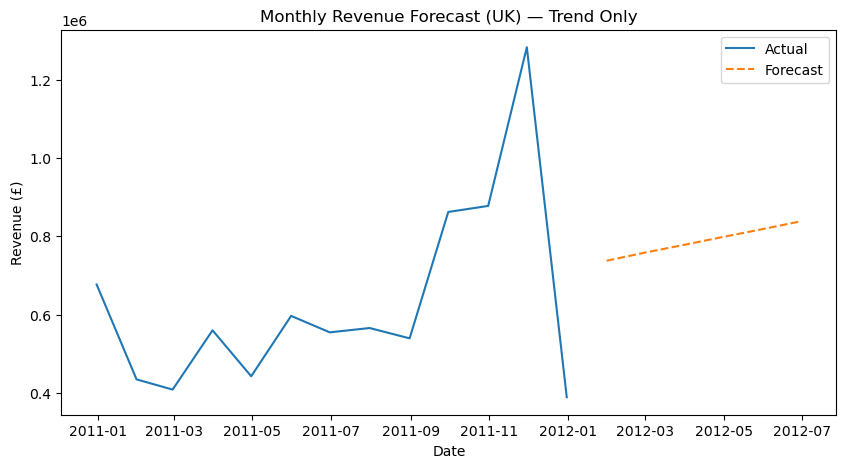

In [40]:
plt.figure(figsize=(10,5))
plt.plot(monthly_ts, label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title('Monthly Revenue Forecast (UK) — Trend Only')
plt.xlabel('Date')
plt.ylabel('Revenue (£)')
plt.legend()
plt.show()

## Blue Dashed Line = Actual monthly revenue (UK)
- Jan–Sep: relatively stable (£400k–£600k)
- Oct–Nov: huge spike (holiday / Q4 surge)
- Jan 2012: sharp drop back to baseline

## Orange Dashed Line = Forecast (Trend-Only Model)
- Starts after the last observed month
- It gradually increases
- Does not try to recreate the holiday spike

The forecast is generated using a trend-only exponential smoothing model. Because the dataset contains approximately one year of data, the model does not explicitly learn recurring seasonality and instead produces a conservative projection based on long-term trend. As a result, short-term holiday spikes are not extrapolated, and the forecast should be interpreted as a baseline revenue estimate rather than a seasonal prediction. 

## Key Takeaways

- Sales are strongly seasonal, with Q4 driving the majority of annual revenue.
- Orders are concentrated on weekdays and during standard business hours, indicating a B2B purchasing pattern.
- A small set of products and shipping fees account for a large share of revenue.
- Trend-based forecasting provides a conservative baseline given limited historical data.

# Limitations

The dataset spans approximately one year of transaction data, which limits the ability to reliably model long-term trends and recurring seasonal patterns. As a result, the forecasting model was intentionally constrained to a trend-only approach to avoid overfitting.

## Seasonality inferred, not learned
While strong seasonal effects (e.g., Q4 holiday spikes) are visible in the historical data, the lack of multiple annual cycles prevents the model from confidently learning and extrapolating recurring seasonality.

## Outlier sensitivity
Holiday-driven revenue spikes and large bulk orders introduce extreme values that can disproportionately influence aggregate metrics and forecasts, particularly in short time series.

## Aggregated forecasting scope
This forecast is generated at an overall monthly revenue level. It does not account for product-level, customer-level, or category-level variation, which may mask important differences in demand patterns.

# Conclusion

This analysis demonstrates how large-scale transactional data can be transformed into actionable business insights through systematic cleaning, feature engineering, and time-based analysis. By identifying key revenue drivers, uncovering purchasing behavior patterns, and producing a conservative revenue forecast, this project highlights the practical application of data analytics in supporting operational planning and decision-making. While the forecast is constrained by limited historical depth, the methodology provides a scalable foundation for deeper analysis as additional data becomes available.